In [143]:
import trimesh
import numpy as np
import open3d as o3d
import copy
import torch
import os
import glob
import ot
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [144]:
seed = 10

random.seed(seed)

np.random.seed(seed)

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [145]:
kitti_root = "KITTI-Sequence"

folders = sorted(os.listdir(kitti_root))

point_clouds = []

for folder in folders:
    folder_path = os.path.join(kitti_root, folder)
    
    if os.path.isdir(folder_path):    
        points_file = os.path.join(folder_path, f"{folder}_points.obj")
        
        if os.path.exists(points_file):
            points = np.array(trimesh.load(points_file).vertices)
            point_clouds.append(points)
        

print(f"Total de nuvens de pontos carregadas: {len(point_clouds)}")

ground_truth = np.load('ground_truth.npy')

Total de nuvens de pontos carregadas: 30


In [146]:
def find_nearest_neighbors_knn(source, target_points):
    point_cloud_tree = o3d.geometry.KDTreeFlann(source)
    source_points = np.asarray(source.points)
    
    source_corr = np.zeros_like(target_points)
    distances = np.zeros(len(target_points))
    
    for i, point in enumerate(target_points):
        _, idx, dist = point_cloud_tree.search_knn_vector_3d(point, 1)
        source_corr[i] = source_points[idx[0]]
        distances[i] = dist[0]
        
    return source_corr, distances

In [ ]:
# point_cloud_list = []

# for i in range(len(point_clouds) - 1):
#     # Carregar e preparar nuvens de pontos
#     source = o3d.geometry.PointCloud()
#     target = o3d.geometry.PointCloud()
#     source.points = o3d.utility.Vector3dVector(point_clouds[i])
#     target.points = o3d.utility.Vector3dVector(point_clouds[i+1])

#     # Colorir para visualização
#     source.paint_uniform_color([0.5, 0.5, 0.5])  # Cinza
#     target.paint_uniform_color([0, 0, 1])        # Azul

#     # Append as a tuple to keep the pair together
#     point_cloud_list.append((source, target))

In [ ]:
# trajectory = [np.eye(4)]

# for idx, (source, target) in enumerate(tqdm(point_cloud_list, desc="Processing point clouds")):
#     source_points = np.asarray(source.points)
#     target_points = np.asarray(target.points)
#     source_centroid = np.mean(source_points, axis=0)
#     target_centroid = np.mean(target_points, axis=0)
#     initial_transform = np.eye(4)
#     initial_transform[:3, 3] = target_centroid - source_centroid
#     source.transform(initial_transform)

#     max_iterations = 50
#     threshold = 1e-6
#     prev_error = float('inf')
#     curr_error = 1000
#     patience = 5
#     consecutive_small_improvements = 7

#     current_transform_cumulative = np.eye(4)

#     for iteration in range(max_iterations):
#         improvement = prev_error - curr_error
#         if improvement < threshold:
#             consecutive_small_improvements -= 1
#             patience -= 1
#             if curr_error > prev_error:
#                 patience -= 1
#             if patience == 0 or consecutive_small_improvements == 0:
#                 break
#         else:
#             patience = max(0, patience - 1)
#             consecutive_small_improvements = 0
#         prev_error = curr_error

#         source_corr, distances = find_nearest_neighbors_knn(source, target_points)
        
#         source_centroid, target_centroid = np.mean(source_corr, axis=0), np.mean(target_points, axis=0)
#         source_centered, target_centered = source_corr - source_centroid, target_points - target_centroid
        
#         cov = target_centered.T @ source_centered
#         U, _, Vt = np.linalg.svd(cov)
        
#         S = np.eye(3)
        
#         if np.linalg.det(U @ Vt) < 0:
#             S[2, 2] = -1
        
#         R = U @ S @ Vt
        
#         t = target_centroid - R @ source_centroid
        
#         transform = np.eye(4)
#         transform[:3, :3] = R
#         transform[:3, 3] = t

#         source = source.transform(transform)
#         curr_error = np.mean(distances)
#         current_transform_cumulative = transform @ current_transform_cumulative

#     trajectory.append(trajectory[-1] @ current_transform_cumulative) # Accumulate with final_trajectory
    
#     # # Visualização da nuvem de pontos alinhada
#     # source_temp = copy.deepcopy(source)
#     # target_temp = copy.deepcopy(target)
#     # source_temp.paint_uniform_color([1, 0.706, 0])
#     # target_temp.paint_uniform_color([0, 0.651, 0.929])
#     # source_temp.transform(transform)
#     # o3d.visualization.draw_geometries([source_temp, target_temp], zoom=0.4459, front=[0.9288, -0.2951, -0.2242], lookat=[1.6784, 2.0612, 1.4451], up=[-0.3402, -0.9189, -0.1996])


In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': '3d'})

# trajectory_array = np.array(trajectory)
# x_coords = trajectory_array[:, 0, 3]*-1
# y_coords = trajectory_array[:, 2, 3]*-1
# z_coords = trajectory_array[:, 1, 3]*-1

# # x_coords = trajectory_array[:, 0, 3]
# # y_coords = trajectory_array[:, 1, 3]
# # z_coords = trajectory_array[:, 2, 3]

# ax1.plot(x_coords, y_coords, z_coords, marker='o', label='Trajectory')
# ax1.set_title('Estimated Vehicle Trajectory')
# ax1.set_xlabel('X-axis')
# ax1.set_ylabel('Y-axis')
# ax1.set_zlabel('Z-axis')
# ax1.legend()

# x_real = ground_truth[:, 0, 3]
# y_real = ground_truth[:, 1, 3]
# z_real = ground_truth[:, 2, 3]

# ax2.plot(x_real, y_real, z_real, marker='o', label='Real Trajectory', color='red')
# ax2.set_title('Real Vehicle Trajectory')
# ax2.set_xlabel('X-axis')
# ax2.set_ylabel('Y-axis')
# ax2.set_zlabel('Z-axis')
# ax2.legend()

# plt.tight_layout()
# plt.show()

In [159]:
point_cloud_list = []
for i in range(len(point_clouds) - 1):
    source = o3d.geometry.PointCloud()
    target = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(point_clouds[i])
    target.points = o3d.utility.Vector3dVector(point_clouds[i+1])

    # Preprocessing (try different combinations and parameters)
    voxel_size = 0.01 # Example voxel size, adjust as needed
    source = source.voxel_down_sample(voxel_size=voxel_size)
    target = target.voxel_down_sample(voxel_size=voxel_size)

    # Statistical outlier removal (example parameters, adjust as needed)
    nb_neighbors = 20
    std_ratio = 2.0
    source, _ = source.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    target, _ = target.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)

    point_cloud_list.append((source, target))

In [160]:
def align_by_pca(source_points, target_points):
    source_centroid = np.mean(source_points, axis=0)
    target_centroid = np.mean(target_points, axis=0)

    source_centered = source_points - source_centroid
    target_centered = target_points - target_centroid

    # PCA for source
    cov_source = np.cov(source_centered.T)
    U_s, _, _ = np.linalg.svd(cov_source)
    R_source = U_s # Rotation matrix from PCA for source

    # PCA for target
    cov_target = np.cov(target_centered.T)
    U_t, _, _ = np.linalg.svd(cov_target)
    R_target = U_t # Rotation matrix from PCA for target

    # Initial rotation to align principal axes
    initial_rotation = R_target @ R_source.T # Rotate source to target's orientation

    # Initial translation is still based on centroids
    initial_translation = target_centroid - initial_rotation @ source_centroid

    initial_transform = np.eye(4)
    initial_transform[:3, :3] = initial_rotation
    initial_transform[:3, 3] = initial_translation
    return initial_transform


In [ ]:
trajectory = [np.eye(4)]

for idx, (source, target) in enumerate(tqdm(point_cloud_list, desc="Processing point clouds")):
    source_points = np.asarray(source.points)
    target_points = np.asarray(target.points)
    source_centroid = np.mean(source_points, axis=0)
    target_centroid = np.mean(target_points, axis=0)
    initial_transform = align_by_pca(source_points, target_points) # Use PCA-based alignment
    source.transform(initial_transform)

    max_iterations = 50
    prev_error = float('inf')
    curr_error = 1000
    patience = 5
    consecutive_small_improvements = 7

    current_transform_cumulative = np.eye(4)

    # ICP parameters
    max_iterations = 100  # Increase max iterations
    threshold = 1e-8 

    for iteration in range(max_iterations):
        source_corr, distances = find_nearest_neighbors_knn(source, target_points)
        
        source_centroid, target_centroid = np.mean(source_corr, axis=0), np.mean(target_points, axis=0)
        source_centered, target_centered = source_corr - source_centroid, target_points - target_centroid
        
        cov = target_centered.T @ source_centered
        U, _, Vt = np.linalg.svd(cov)
        
        S = np.eye(3)
        
        if np.linalg.det(U @ Vt) < 0:
            S[2, 2] = -1
        
        R = U @ S @ Vt
        
        t = target_centroid - R @ source_centroid
        
        transform = np.eye(4)
        transform[:3, :3] = R
        transform[:3, 3] = t

        source = source.transform(transform)

        curr_error = np.mean(distances)
        # print(f"Iteration {iteration+1}, Error: {curr_error}") # Monitor error

        if prev_error - curr_error < threshold: # Simple threshold on error reduction
            break
        prev_error = curr_error
        
        current_transform_cumulative = transform @ current_transform_cumulative

    trajectory.append(trajectory[-1] @ current_transform_cumulative) # Accumulate with final_trajectory
    
    # # Visualização da nuvem de pontos alinhada
    # source_temp = copy.deepcopy(source)
    # target_temp = copy.deepcopy(target)
    # source_temp.paint_uniform_color([1, 0.706, 0])
    # target_temp.paint_uniform_color([0, 0.651, 0.929])
    # source_temp.transform(transform)
    # o3d.visualization.draw_geometries([source_temp, target_temp], zoom=0.4459, front=[0.9288, -0.2951, -0.2242], lookat=[1.6784, 2.0612, 1.4451], up=[-0.3402, -0.9189, -0.1996])

Processing point clouds: 100%|██████████| 29/29 [08:15<00:00, 17.09s/it]


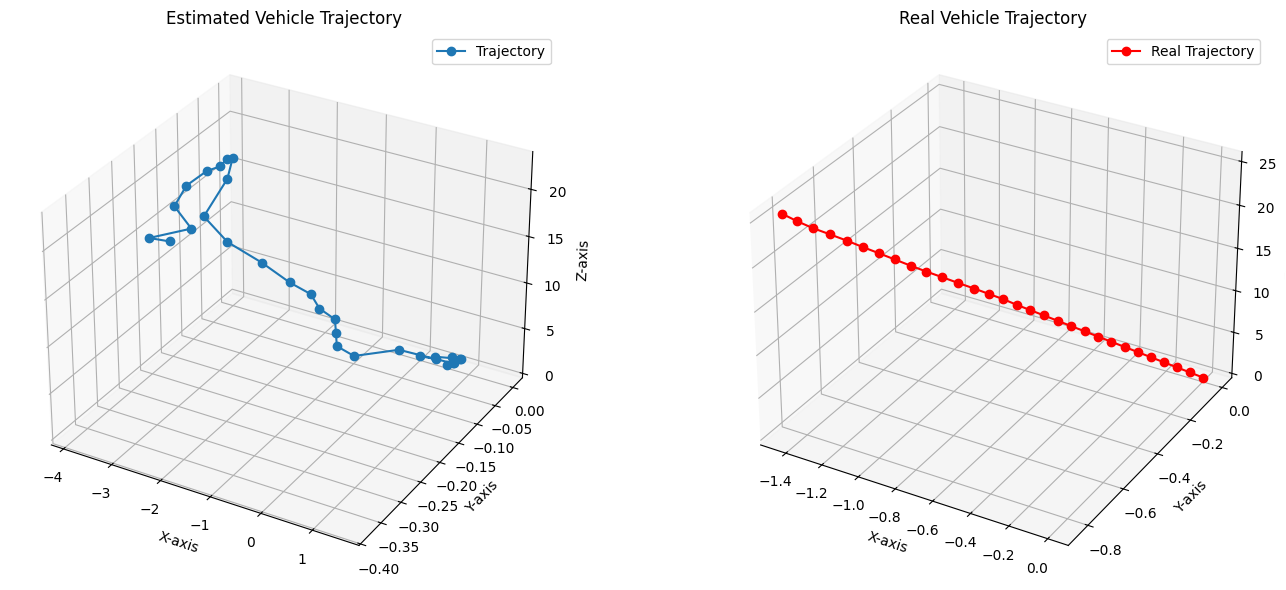

In [165]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': '3d'})

trajectory_array = np.array(trajectory)
x_coords = trajectory_array[:, 0, 3]
y_coords = trajectory_array[:, 2, 3]
z_coords = trajectory_array[:, 1, 3]*-1

# x_coords = trajectory_array[:, 0, 3]
# y_coords = trajectory_array[:, 1, 3]
# z_coords = trajectory_array[:, 2, 3]

ax1.plot(x_coords, y_coords, z_coords, marker='o', label='Trajectory')
ax1.set_title('Estimated Vehicle Trajectory')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('Z-axis')
ax1.legend()

x_real = ground_truth[:, 0, 3]
y_real = ground_truth[:, 1, 3]
z_real = ground_truth[:, 2, 3]

ax2.plot(x_real, y_real, z_real, marker='o', label='Real Trajectory', color='red')
ax2.set_title('Real Vehicle Trajectory')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.set_zlabel('Z-axis')
ax2.legend()

plt.tight_layout()
plt.show()